# Deploying ML Model - Chapter12 Wei-Meng Lee's Book
 - Using data from DATA/diabetes.csv for a prediction of who has diabetes.

## 1) Loading data

In [1]:
import pandas as pd
data = pd.read_csv('DATA/diabetes.csv')
data


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## 2) Cleaning data

In [2]:
# check if there are no missing or erroneous values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [3]:
import numpy as np 

# check for zero values
print(data.eq(0).sum())

# replace zero with NaN for any places (but NOT for Pregnancies and Outcome- They're OK)
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] = \
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].replace(0,np.NaN)

# replace NaN with mean value of each column for any places
data.fillna(data.mean(),inplace=True)
data.head()


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


## 3) Examing the Correlation between the Features
- check how each feature impacts the final Outcome.

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.127911       0.208522       0.082989   
Glucose                      0.127911  1.000000       0.218367       0.192991   
BloodPressure                0.208522  0.218367       1.000000       0.192816   
SkinThickness                0.082989  0.192991       0.192816       1.000000   
Insulin                      0.056027  0.420157       0.072517       0.158139   
BMI                          0.021565  0.230941       0.281268       0.542398   
DiabetesPedigreeFunction    -0.033523  0.137060      -0.002763       0.100966   
Age                          0.544341  0.266534       0.324595       0.127872   
Outcome                      0.221898  0.492928       0.166074       0.215299   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies               0.056027  0.021565                 -0.033523   
Glucose                   0.420157  0.230

<Figure size 1440x1152 with 0 Axes>

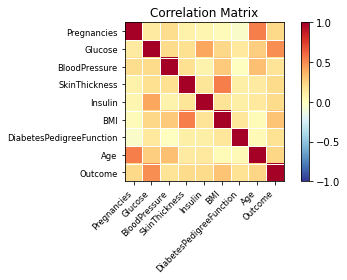

In [4]:
# full correlations
corr = data.corr()
print(corr)

# plot the correlation matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))
sm.graphics.plot_corr(corr, xnames=list(corr.columns),normcolor=True) 
plt.show()

# get the top 4 features (including Outcome) that have the highest correlation with Outcome
print('================')
print('TOP 4:')
print('================')
print(corr['Outcome'].nlargest(4))

# get the top 3 targeted feature
top3 = [corr['Outcome'].nlargest(4).index[i] for i in (1,2,3)]

## 4) Evaluating the Algorithms
- Logistic Regression
- K-nearest Neighbors (KNN)
- Support Vector Machines (SVM) - Linear Kernels
- SVM -sRBF Kernels

In [5]:
# Set number of folds for the cross-validation
cvf = 10

In [6]:
# Logistic Regression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

X = data[top3]
y = data.Outcome

log_regress = linear_model.LogisticRegression()
log_regress_score = cross_val_score(log_regress, X, y, cv=cvf,scoring='accuracy').mean()
print(log_regress_score)

0.7669856459330144


In [7]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# list that holds the crossing-validates score
cv_scores =[]

# odd list of K for KNN
ks = list(range(1,int(len(X)*(cvf-1)/cvf),2))
# lopping
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=cvf,scoring='accuracy').mean()
    cv_scores.append(score)

# get final score as the highest score in the list cv_cores
knn_score = max(cv_scores)

# get the optimal k that gives the knn_score
k_optimal = ks[cv_scores.index(knn_score)]
print(knn_score)
print(f'The optimal number of the neighbors: k = {k_optimal}')


0.7721462747778537
The optimal number of the neighbors: k = 19


In [8]:
# SVM: linear kernel
from sklearn import svm

linear_svm = svm.SVC(kernel='linear')
linear_svm_score = cross_val_score(linear_svm , X, y, cv=cvf,scoring='accuracy').mean()
print(linear_svm_score)

0.7656527682843473


In [9]:
# SVM: RBF kernel

rbf_svm = svm.SVC(kernel='rbf')
rbf_svm_score = cross_val_score(rbf_svm , X, y, cv=cvf,scoring='accuracy').mean()
print(rbf_svm_score)

0.765704032809296


In [12]:
cv_results = pd.DataFrame(data={'Model':['Logistic Regression','K-Nearest Neighbors','SVM Linear Kernel','SVM RBF Kernel'],
                                'cv_score':[log_regress_score,knn_score,linear_svm_score,rbf_svm_score]})
cv_results.sort_values(by='cv_score',ascending=False)


,Model,cv_score
1,K-Nearest Neighbors,0.772146
0,Logistic Regression,0.766986
3,SVM RBF Kernel,0.765704
2,SVM Linear Kernel,0.765653


## 5) Training and Saving the Model

In [16]:
# create model
knn = KNeighborsClassifier(k_optimal)
knn.fit(X,y)

# save the model, using write and binary mode
import pickle
pickle.dump(knn,open('TRAINED_MODELS/diabetes.sav','wb'))

## 6) Loading and Testing the Saved Model

In [33]:
# load the model
loaded_model = pickle.load(open('TRAINED_MODELS/diabetes.sav','rb'))

# provide an example
glucose = 65
bmi = 70
age = 50

# get the prediction
prediction = loaded_model.predict([[glucose,bmi,age]])
prob = loaded_model.predict_proba([[glucose,bmi,age]])
print('=========================')
print('RESULT:')
if (prediction[0] == 0):
    print('Non-diabetic')
else:
    print('Diabetic')

print(f'Confidence: {prob[0][0]*100:.2f} %')
print('=========================')

RESULT:
Non-diabetic
Confidence: 94.74 %
